In [1]:
import os
import time
import glob
import tables as tb
import numpy  as np
import pandas as pd

from invisible_cities.core.system_of_units import year, kg, dalton
from invisible_cities.evm.mixer import get_mixer_nevents

os.environ["ZFIT_DISABLE_TF_WARNINGS"] = "1"
import zfit
import hist

%matplotlib ipympl
import matplotlib.pyplot as plt

plt.rcParams["font.size"]      = 10
plt.rcParams["font.family"]    = "sans-serif"
plt.rcParams["font.monospace"] = "Computer Modern Sans Serif"
plt.rcParams["figure.max_open_warning"] = False

/Users/gonzalo/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/zfit/__init__.py:50: UserWarning: This is an ALPHA version of zfit for feature testing, do NOT use it in production! It is NOT stable and contains bugs and untested features. For production use, please use the last beta stable version of zfit.
  warnings.warn(


## Load PDFs

In [2]:
def create_pdf_from_histogram(bins, histo, obs, name):
    h    = hist.Hist(hist.axis.Variable(edges=bins, name=name), data=histo)
    pdf  = zfit.pdf.HistogramPDF(h)
    data = zfit.Data.from_numpy (obs=obs, array=binc, weights=h)
    pdf  = zfit.pdf.KDE1DimExact(obs=obs, data=data, bandwidth=np.mean(np.diff(bins)))
    return pdf

In [3]:
data_filename = "./create_pdfs/pdfs.h5"

# create pdfs
with tb.open_file(data_filename) as h5file:
    
    # energy pdfs
    name = "energy"
    bins = h5file.root.energy.bins.read()
    binc = (bins[1:] + bins[:-1])/2.
    emin, emax = bins[0], bins[-1]
    energy_obs = zfit.Space(name, limits=(emin, emax))
    
    h = h5file.root.energy.bb0nu.read()
    pdf_energy_bb = create_pdf_from_histogram(bins, h, energy_obs, name)
    h = h5file.root.energy.Bi.read()
    pdf_energy_Bi = create_pdf_from_histogram(bins, h, energy_obs, name)
    h = h5file.root.energy.Tl.read()
    pdf_energy_Tl = create_pdf_from_histogram(bins, h, energy_obs, name)
    
    # eblob2
    name = "eblob2"
    bins = h5file.root.eblob2.bins.read()
    binc = (bins[1:] + bins[:-1])/2.
    eb2min, eb2max = bins[0], bins[-1]
    eblob2_obs     = zfit.Space(name, limits=(eb2min, eb2max))
    
    h = h5file.root.eblob2.bb0nu.read()
    pdf_eblob2_bb = create_pdf_from_histogram(bins, h, eblob2_obs, name)
    h = h5file.root.eblob2.Bi.read()
    pdf_eblob2_Bi = create_pdf_from_histogram(bins, h, eblob2_obs, name)
    h = h5file.root.eblob2.Tl.read()
    pdf_eblob2_Tl = create_pdf_from_histogram(bins, h, eblob2_obs, name)
    
    
pdf_bb = zfit.pdf.ProductPDF([pdf_energy_bb, pdf_eblob2_bb])
pdf_Tl = zfit.pdf.ProductPDF([pdf_energy_Tl, pdf_eblob2_Tl])
pdf_Bi = zfit.pdf.ProductPDF([pdf_energy_Bi, pdf_eblob2_Bi])

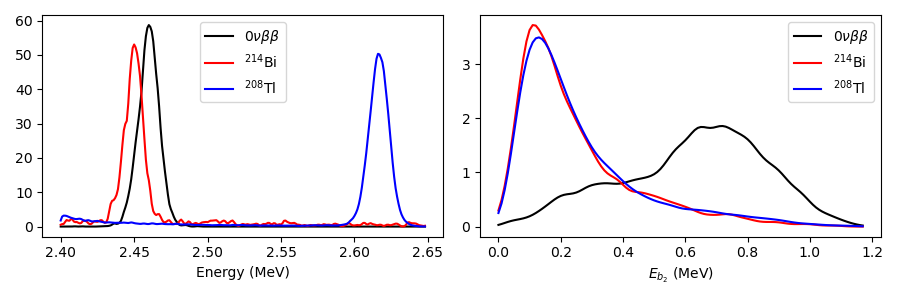

In [4]:
plt.figure(figsize=[9, 3])

plt.subplot(121)
E = np.arange(*energy_obs.limit1d, 0.001)
plt.plot(E, pdf_energy_bb.pdf(E), color="k", label=r"$0\nu\beta\beta$")
plt.plot(E, pdf_energy_Bi.pdf(E), color="r", label=r"$^{214}$Bi")
plt.plot(E, pdf_energy_Tl.pdf(E), color="b", label=r"$^{208}$Tl")
plt.xlabel("Energy (MeV)")
plt.legend()

plt.subplot(122)
E = np.arange(*eblob2_obs.limit1d, 0.01)
plt.plot(E, pdf_eblob2_bb.pdf(E), color="k", label=r"$0\nu\beta\beta$")
plt.plot(E, pdf_eblob2_Bi.pdf(E), color="r", label=r"$^{214}$Bi")
plt.plot(E, pdf_eblob2_Tl.pdf(E), color="b", label=r"$^{208}$Tl")
plt.xlabel(r"$E_{b_2}$ (MeV)")
plt.legend()

plt.tight_layout()

## Generate random experiment

In [5]:
T12_0nubb  = 1.e+25 * year
enrichment = 0.9
xenon_mass = 71.5 * kg
exposure   = 3. * year
detector_db = "next100"
isotopes = ["208Tl", "214Bi", "0nubb"]

# ic efficiencies
eff_ic = pd.read_csv("efficiencies_ic.csv").set_index(["Isotope", "G4Volume"])
# selection efficiencies
# eff_sel = pd.read_csv("efficiencies_selection.csv").set_index(["Isotope", "G4Volume"])
eff_sel = pd.read_hdf(data_filename, "efficiencies")
# efficiency
total_eff = ((eff_ic.nreco/eff_ic.nsim) * (eff_sel.nevts/eff_ic.nreco)).fillna(0).loc[isotopes].sort_index()

N0 = enrichment*(xenon_mass/(136. * dalton))

# get event df with (g4volume, isotope, nevts)
nevent_df = get_mixer_nevents(exposure, detector_db, isotopes)

# get number of decays of signal-like events
if "0nubb" in isotopes:
    nevts = N0 * (np.log(2)/T12_0nubb) * exposure
    nevent_df.loc[len(nevent_df)] = ("ACTIVE", "0nubb", nevts)

nevent_df = nevent_df.set_index(["Isotope", "G4Volume"]).sort_index()
    
# assert sorted indexes
indexes = total_eff.index
assert (indexes == nevent_df.index).all()

In [6]:
# randomize (binomial)
nevents = np.random.binomial(nevent_df.nevts, total_eff)
nevents_roi = pd.DataFrame(index=indexes, data={"nevts": nevents})
nevents = nevents_roi.groupby(level=0).nevts.sum()
print(nevents)

Isotope
0nubb      22
208Tl    4235
214Bi     118
Name: nevts, dtype: int64


In [7]:
t0 = time.time()

# divide the sample in signal and background, since Eb2 cut has different efficiencies
bb_sample = pdf_bb.sample(nevents.get("0nubb")).numpy()
Tl_sample = pdf_Tl.sample(nevents.get("208Tl")).numpy()
Bi_sample = pdf_Bi.sample(nevents.get("214Bi")).numpy()

sample = np.concatenate([bb_sample, Tl_sample, Bi_sample])

print("Time (s):", time.time()-t0)

Time (s): 4.513753175735474


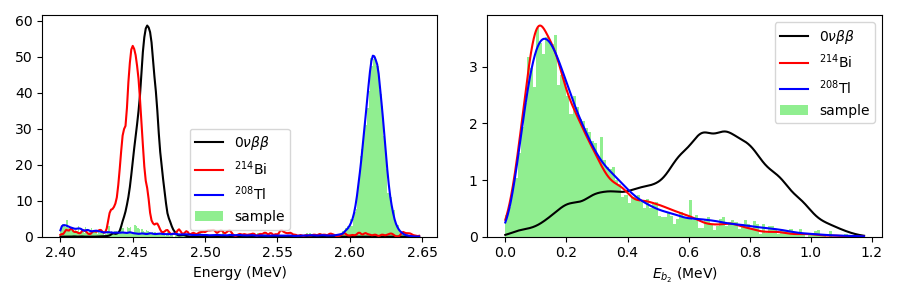

In [8]:
plt.figure(figsize=[9, 3])

plt.subplot(121)
E = np.arange(*energy_obs.limit1d, 0.001)
plt.plot(E, pdf_energy_bb.pdf(E), color="k", label=r"$0\nu\beta\beta$")
plt.plot(E, pdf_energy_Bi.pdf(E), color="r", label=r"$^{214}$Bi")
plt.plot(E, pdf_energy_Tl.pdf(E), color="b", label=r"$^{208}$Tl")

bins = np.arange(*energy_obs.limit1d, 0.001)
plt.hist(sample[:, 0], bins=bins, color="lightgreen", label="sample", density=True)
plt.xlabel("Energy (MeV)")
plt.legend()

plt.subplot(122)
E = np.arange(*eblob2_obs.limit1d, 0.001)
plt.plot(E, pdf_eblob2_bb.pdf(E), color="k", label=r"$0\nu\beta\beta$")
plt.plot(E, pdf_eblob2_Bi.pdf(E), color="r", label=r"$^{214}$Bi")
plt.plot(E, pdf_eblob2_Tl.pdf(E), color="b", label=r"$^{208}$Tl")

bins = np.arange(*eblob2_obs.limit1d, 0.01)
plt.hist(sample[:, 1], bins=bins, color="lightgreen", label="sample", density=True)
plt.xlabel(r"$E_{b_2}$ (MeV)")
plt.legend()

plt.tight_layout()

## Apply signal cut $E_{b_2}$ > 0.54 MeV

In [9]:
Eb2 = 0.54

bb_selected_sample = bb_sample[bb_sample[:, -1]>Eb2]
Tl_selected_sample = Tl_sample[Tl_sample[:, -1]>Eb2]
Bi_selected_sample = Bi_sample[Bi_sample[:, -1]>Eb2]

selected_sample = np.concatenate([bb_selected_sample, Tl_selected_sample, Bi_selected_sample])

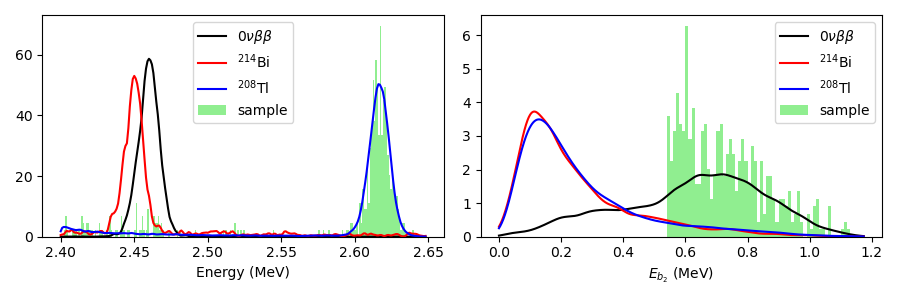

In [10]:
plt.figure(figsize=[9, 3])

plt.subplot(121)
E = np.arange(*energy_obs.limit1d, 0.001)
plt.plot(E, pdf_energy_bb.pdf(E), color="k", label=r"$0\nu\beta\beta$")
plt.plot(E, pdf_energy_Bi.pdf(E), color="r", label=r"$^{214}$Bi")
plt.plot(E, pdf_energy_Tl.pdf(E), color="b", label=r"$^{208}$Tl")

bins = np.arange(*energy_obs.limit1d, 0.001)
plt.hist(selected_sample[:, 0], bins=bins, color="lightgreen", label="sample", density=True)
plt.xlabel("Energy (MeV)")
plt.legend()

plt.subplot(122)
E = np.arange(*eblob2_obs.limit1d, 0.001)
plt.plot(E, pdf_eblob2_bb.pdf(E), color="k", label=r"$0\nu\beta\beta$")
plt.plot(E, pdf_eblob2_Bi.pdf(E), color="r", label=r"$^{214}$Bi")
plt.plot(E, pdf_eblob2_Tl.pdf(E), color="b", label=r"$^{208}$Tl")

bins = np.arange(*eblob2_obs.limit1d, 0.01)
plt.hist(selected_sample[:, 1], bins=bins, color="lightgreen", label="sample", density=True)
plt.xlabel(r"$E_{b_2}$ (MeV)")
plt.legend()

plt.tight_layout()

## Fit

In [11]:
# RUN ONCE!!
N = int(10*nevent_df.nevts.sum())
nbb = zfit.Parameter("nbb", 1, 0, N)
nTl = zfit.Parameter("nTl", 1, 0, N)
nBi = zfit.Parameter("nBi", 1, 0, N)

pdf_energy_bb.set_yield(nbb)
pdf_energy_Tl.set_yield(nTl)
pdf_energy_Bi.set_yield(nBi)

In [12]:
model = zfit.pdf.SumPDF(pdfs=[pdf_energy_bb, pdf_energy_Tl, pdf_energy_Bi])

# minimizer
minimizer = zfit.minimize.Minuit(gradient=True)

data = zfit.Data.from_numpy(obs=energy_obs, array=selected_sample[:, 0])

In [13]:
t0 = time.time()

# loss
nll = zfit.loss.ExtendedUnbinnedNLL(model, data)
nll.create_new()

# fit
result = minimizer.minimize(nll)

# error
param_hesse = result.hesse()

print("Valid:", result.valid)
print(result.params)

print("Time (min):", (time.time()-t0) / 60)

/Users/gonzalo/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1170: ChangedFeatureWarning: The behavior of this functionality recently changed.To turn this warning off, use `zfit.settings.changed_warnings.hesse_name = False`  or 'all' with `zfit.settings.changed_warnings.all = False
Default name of hesse (which is currently the method name such as `minuit_hesse`or `hesse_np`) has changed to `hesse` (it still adds the old one as well. This will be removed in the future). INSTRUCTIONS: to stay compatible,  change wherever you access the error to 'hesse' (if you don't explicitly specify the name in hesse(...).
  warn_changed_feature(message, "hesse_name")


Valid: True
name          hesse    value    at limit
------  -----------  -------  ----------
nbb     +/-     6.9  14.5236       False
nTl     +/-      25  591.464       False
nBi     +/-     9.1  23.8605       False
Time (min): 0.04616905053456624


In [14]:
print("Expected bb:", len(bb_selected_sample))
print("Expected Tl:", len(Tl_selected_sample))
print("Expected Bi:", len(Bi_selected_sample))

Expected bb: 22
Expected Tl: 592
Expected Bi: 16
